In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pydataset import data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
import wrangle

In [2]:
df = wrangle.acquire_and_prep_data()

In [3]:
df.head()

,sqft,bathroomcnt,bedroomcnt,zip_code,taxamount,home_value,yearbuilt,tax_rate,county
0,1000,0.0,0,97083,212.46,27400.0,2002,0.78,Ventura County
1,1604,2.0,4,96415,6089.82,498347.0,1950,1.22,Los Angeles County
2,2384,3.0,3,96452,6679.55,549917.0,1937,1.21,Los Angeles County
3,1574,2.0,3,97319,3876.31,235272.0,1990,1.65,Los Angeles County
4,1619,2.0,2,97329,4206.15,340000.0,1983,1.24,Los Angeles County


In [6]:
train, validate, test = wrangle.zillow_split(df)
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (10472, 9)
validate -> (4488, 9)
test -> (3741, 9)


In [12]:
# Split into X and y data frames
X_train = train.drop(columns=['home_value'])
X_validate = validate.drop(columns=['home_value'])
X_test = test.drop(columns=['home_value'])

y_train = train[['home_value']]
y_validate = validate[['home_value']]
y_test = test[['home_value']]


In [14]:
# Create scaler object
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=True).fit(X_train.drop(columns='county'))

X_train_scaled = scaler.transform(X_train.drop(columns='county'))
X_validate_scaled = scaler.transform(X_validate.drop(columns='county'))
X_test_scaled = scaler.transform(X_test.drop(columns='county'))


In [16]:
train, validate, test = wrangle.add_scaled_columns(train, validate, test, scaler, train.drop(columns=['home_value', 'county', 'zip_code']).columns)

In [17]:
train.head()

,sqft,bathroomcnt,bedroomcnt,zip_code,taxamount,home_value,yearbuilt,tax_rate,county,sqft_scaled,bathroomcnt_scaled,bedroomcnt_scaled,taxamount_scaled,yearbuilt_scaled,tax_rate_scaled
3757,1621,2.0,3,96325,3062.49,273285.0,1980,1.12,Los Angeles County,0.160594,0.444444,0.6,0.016883,0.740741,0.083461
11816,2448,3.0,4,96954,14200.98,1030737.0,2014,1.38,Orange County,0.252187,0.666667,0.8,0.079993,0.992593,0.103369
6883,1134,2.0,4,96524,2014.56,152322.0,1953,1.32,Los Angeles County,0.106656,0.444444,0.8,0.010946,0.540741,0.098775
13320,1794,3.0,3,96387,6504.86,537067.0,1982,1.21,Los Angeles County,0.179754,0.666667,0.6,0.036387,0.755556,0.090352
1642,3014,2.0,3,96403,7916.70,717821.0,1948,1.10,Los Angeles County,0.314874,0.444444,0.6,0.044387,0.503704,0.081930


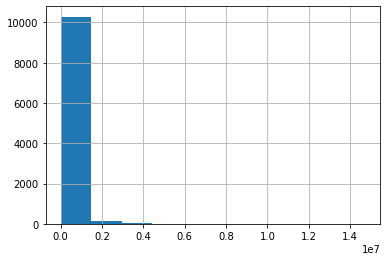

In [20]:
# looking at the distribution of home values. Going to use the mean
train.home_value.hist()

In [23]:
# Establishing a baseline. Pre Req 1
baseline = train.home_value.mean()
baseline

397225.89495798317

In [24]:
# Pre-req Part 2 - build/identify a super simple linear model
# Use the OLS (ordinary least square method)
from statsmodels.formula.api import ols

In [31]:
# The arguments to the ols function are the column names as strings, separated by ~
# ols("y ~ x") 
# ols("target ~ feature")
model = ols('home_value ~ sqft', df).fit()

In [32]:
# Pre req 3, calculate residuals/error
evaluate = pd.DataFrame()

# setting up x independent variable
evaluate['x'] = df.sqft

# setting up y dependent variable
evaluate['y'] = df.home_value

# setting up the baseline. baseline was established above
evaluate['baseline'] = baseline

# setting up y-hat AKA the predicted y-values. Just introduce model
evaluate['yhat'] = model.predict()

# calculate the baseline residuals (residual - actual y)
evaluate['baseline_residuals'] = evaluate.baseline - evaluate.y

# calculate the model residuals (y-hat - model)
evaluate['model_residual'] = evaluate.yhat - evaluate.y

evaluate.head()

,x,y,baseline,yhat,baseline_residuals,model_residual
0,1000,27400.0,397225.894958,203281.465329,369825.894958,175881.465329
1,1604,498347.0,397225.894958,384117.007371,-101121.105042,-114229.992629
2,2384,549917.0,397225.894958,617646.349742,-152691.105042,67729.349742
3,1574,235272.0,397225.894958,375135.109587,161953.894958,139863.109587
4,1619,340000.0,397225.894958,388607.956262,57225.894958,48607.956262


In [33]:

# Calculate if the model beats the baseline
# Square errors for 2 reasons
# 1. Squaring large numbers increases their magnitude (opposite for small)
# 2. Squaring removes negative residuals

# Baseline sum of squared errors
baseline_sse = (evaluate.baseline_residuals ** 2).sum()

# Model sum of squared errors
model_sse = (evaluate.model_residual ** 2).sum()

# Checking if our model beats our baseline
if model_sse < baseline_sse:
    print('Our model out performed our baseline')
    print('It makes sense to evaluate this model more thoroughly')
else:
    print('The baseline out performed the model')
    
print('Baseline SSE', baseline_sse)
print('Model SSE', model_sse)


Our model out performed our baseline
It makes sense to evaluate this model more thoroughly
Baseline SSE 3364207680492154.0
Model SSE 2524796664160337.0


## Now let's consider evaluation metrics
### Sum of Square Error (SSE)
- Squaring makes larger errors more significant
- Squaring also removes negative residuals
### Mean Squared Error (MSE)
- Average of all the squared errors
### Root Mean Squared Error (RMSE)
- Super useful
- Converts back to the same units

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [35]:
# Sum the squares of the baseline risidual/error
model_sse = (evaluate.model_residual ** 2).sum()

# Take the average of the sum of squared errors
# mse = model_sse / len(evaluate)

# We can also calculate using sklearns mean_squared_error function
mse = mean_squared_error(evaluate.y, evaluate.yhat)

# Now we'll take the Square Root of the Sum of Errors
# Taking the square root is nice because the units of the error 
# will be in the same units as the target variable.
rmse = sqrt(mse)

print("SSE is", model_sse, " which is the sum sf squared errors")
print("MSE is", mse, " which is the average squared error")
print("RMSE is", rmse, " which is the square root of the MSE")

SSE is 2524796664160337.0  which is the sum sf squared errors
MSE is 135008644679.98166  which is the average squared error
RMSE is 367435.22514857183  which is the square root of the MSE


## Evaluating Model Significance
$R^2$ tells you how well your model fits the data by measuring the strength of the relationship between your model and the dependent variable. However, it is not a formal test for the relationship. The F-test of overall significance is the hypothesis test for this relationship. It indicates whether your linear regression model provides a better fit to the data than a model that contains no independent variables.

If the overall F-test is significant (evident through the p-value of the F statistic), you can conclude that $R^2$ does not equal zero, and the correlation between the model and dependent variable is statistically significant.

In [36]:
# The model commented below is our model
# model = ols('home_value ~ sqft', df).fit()
r2 = model.rsquared
print('R-squared = ', round(r2,3))

R-squared =  0.25


We will now compute the p-value to determine if our test is significant, i.e. can we trust that the explained variance means what we think it means? If we have a high $R^2$, does it really mean that there is correlation? If we have only two datapoints, then no

In [37]:
f_pval = model.f_pvalue
print('p-value for the model significance =', f_pval)
f_pval < .05

p-value for the model significance = 0.0


True

- Null hypothesis is that a model not built w/ the independent variables explains the relationship
- Alternative hypothesis is that our model built on independent varibles explains the relationship, validates that $R^2$
- If p is less than 0.05, you're OK to conclude that your regression model fits the data better than the model with no independent variables, meaning the independent variables in your model improve the fit.
- If greater than 0.05, it's probably better to stop using this set of features.
- Basically, if the p is low, we can reject the null hypothesis.
- And that means we can accept the model as statistically significant

In [38]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted
    # ls line style allows dotted line
    plt.hlines(0, actual.min(), actual.max(), ls=':')   
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title('Actual vs Residual')
    return plt.gca()

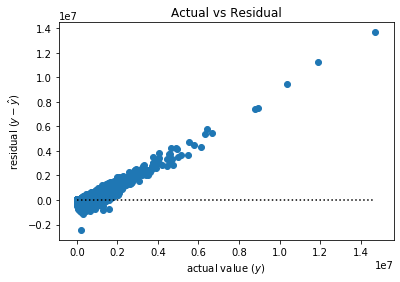

In [39]:
plot_residuals(evaluate.y, evaluate.yhat)

In [40]:
# The arguments to the ols function are the column names as strings, separated by ~
# ols("y ~ x") 
# ols("target ~ feature")
model2 = ols('home_value ~ bathroomcnt', df).fit()

In [41]:
# Pre req 3, calculate residuals/error
evaluate = pd.DataFrame()

# setting up x independent variable
evaluate['x'] = df.bathroomcnt

# setting up y dependent variable
evaluate['y'] = df.home_value

# setting up the baseline. baseline was established above
evaluate['baseline'] = baseline

# setting up y-hat AKA the predicted y-values. Just introduce model
evaluate['yhat'] = model.predict()

# calculate the baseline residuals (residual - actual y)
evaluate['baseline_residuals'] = evaluate.baseline - evaluate.y

# calculate the model residuals (y-hat - model)
evaluate['model_residual'] = evaluate.yhat - evaluate.y

evaluate.head()

,x,y,baseline,yhat,baseline_residuals,model_residual
0,0.0,27400.0,397225.894958,203281.465329,369825.894958,175881.465329
1,2.0,498347.0,397225.894958,384117.007371,-101121.105042,-114229.992629
2,3.0,549917.0,397225.894958,617646.349742,-152691.105042,67729.349742
3,2.0,235272.0,397225.894958,375135.109587,161953.894958,139863.109587
4,2.0,340000.0,397225.894958,388607.956262,57225.894958,48607.956262


In [42]:
# Baseline sum of squared errors
baseline_sse = (evaluate.baseline_residuals ** 2).sum()

# Model sum of squared errors
model_sse = (evaluate.model_residual ** 2).sum()

# Checking if our model beats our baseline
if model_sse < baseline_sse:
    print('Our model out performed our baseline')
    print('It makes sense to evaluate this model more thoroughly')
else:
    print('The baseline out performed the model')
    
print('Baseline SSE', baseline_sse)
print('Model SSE', model_sse)

Our model out performed our baseline
It makes sense to evaluate this model more thoroughly
Baseline SSE 3364207680492154.0
Model SSE 2524796664160337.0
